# SPY prediction with LSTM in PyTorch 


Dataset: come from alpha_vatange https://anaconda.org/conda-forge/alpha_vantage

Some of codes here follows the Alpha Academy: https://www.alphavantage.co/academy/

In [ ]:
# install the alpha_vantage module (alternatively, access the api directly)
!pip install alpha_vantage

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

In [3]:
api_key = open('alpha_vantage_api_key.txt', 'r').read() # my api key is stored in the text file

In [101]:
config = {
    "alpha_vantage": {
        "key": api_key, 
        "symbol": "SPY",
        "outputsize": "full",
        "interval": "1min",
        "datatype": "csv",
        
    },
    "data": {
        "window_size": 60,
        "train_split_size": 0.80,
        "output_size": 10,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days (ignore this for now)
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 8, # we are using open, close, volume, MACD, etc as input features
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [5]:
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"], output_format='pandas')
    intra_data, meta_data = ts.get_intraday(config["alpha_vantage"]["symbol"], 
                                      outputsize=config["alpha_vantage"]["outputsize"],
                                      interval=config["alpha_vantage"]["interval"])
    
    ti = TechIndicators(key=config["alpha_vantage"]["key"], output_format='pandas')
    technical_indicators, meta = ti.get_macd(config["alpha_vantage"]["symbol"],
                                       interval=config["alpha_vantage"]["interval"])
    
    # merge the two dataframes because there are some different dates between the two dataframes 
    # (different default ranges maybe)
    data = intra_data.merge(technical_indicators, left_index=True, right_index=True)

    # data_date = [date for date in data.keys()]
    # data_date.reverse()

    # change the column names to something easier to type
    columns_name = ["open", "high", "low", "close", "volume", "macd", "macd_signal", "macd_hist"]
    data.columns = columns_name

    # reverse the data so that the data is in chronological order (start from the oldest date) 
    reversed_data = data.iloc[::-1]

    # data = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    # data.reverse()
    # data = np.array(data_open)

    # generate the index for each data point
    num_data_points = reversed_data.shape[0]
    data_date = np.arange(0, num_data_points, 1)

    # display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    # print("Number data points", num_data_points, display_date_range)

    return reversed_data, data_date

data, data_date = download_data(config)

In [82]:
# train on a larger dataset
SPY_prices = pd.read_csv('SPY_prices.csv')
SPY_MACD = pd.read_csv('SPY_MACD.csv')

# drop the original index column and rename the date column as index
SPY_prices.set_index('time', inplace=True)
SPY_MACD.set_index('time', inplace=True)

# before merge, unify the index one is MM/DD/YYYY %H:%M and the other is YYYY-MM-DD %H:%M:%S
SPY_prices.index = pd.to_datetime(SPY_prices.index, format='%m/%d/%Y %H:%M')
SPY_MACD.index = pd.to_datetime(SPY_MACD.index, format='%Y-%m-%d %H:%M:%S')


data = SPY_prices.merge(SPY_MACD, left_index=True, right_index=True)
data = data.iloc[::-1]
data_date = np.arange(0, data.shape[0], 1)

(18007, 8)

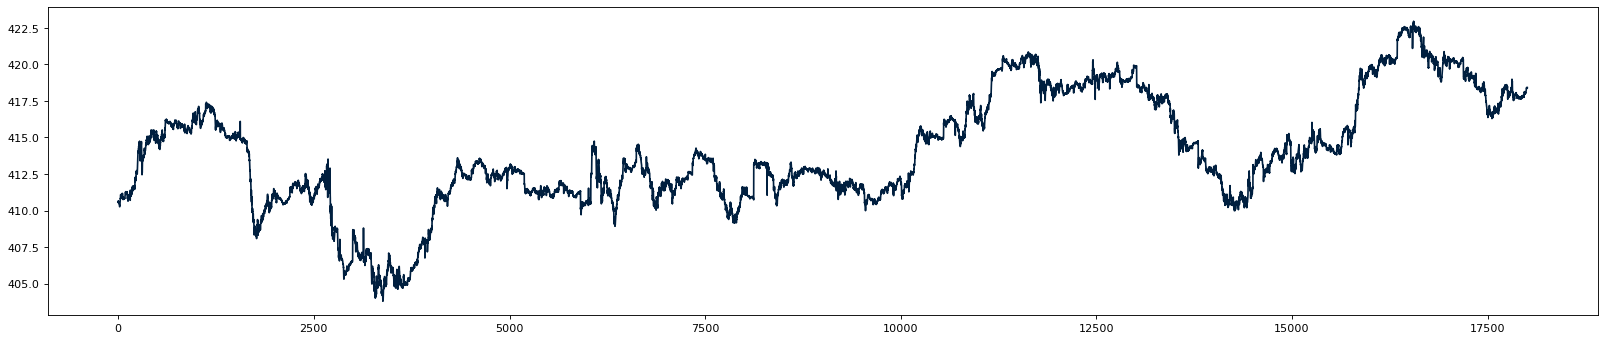

In [83]:
# plot 

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data["open"], color=config["plots"]["color_actual"])

# plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
# plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()


Data normalization is crucial to LSTM model, because gradient descent are used as the optimization technique.

In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# normalize
normalized_data = scaler.fit_transform(data)


def prepare_data_x(x, window_size, output_size=1):
    # perform windowing
    m, n = x.shape
    data_x = np.lib.stride_tricks.sliding_window_view(x, window_shape = (window_size + output_size, n))

    # the above is of shape (m - window_size + 1, 1, window_size, n), we need to get rid of the dimension 1
    data_x = np.squeeze(data_x)
    return data_x[:, :-output_size, :], data_x[:, -output_size:, :]  


# def prepare_data_y(x, window_size):
#     # take the high value as the target
#     data_high = x[:, 1]

#     # take the low value as the second target
#     data_low = x[:, 2]

#     output1 = data_high[window_size:]
#     output2 = data_low[window_size:]

#     return output1, output2

def prepare_data_y(x, window_size, output_size=1):
    # take close prices within next {output_size} minutes as the target
    data_y = x[window_size:][:, 3]
    output = np.lib.stride_tricks.sliding_window_view(data_y, window_shape = (output_size, ))
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data, window_size=config["data"]["window_size"], output_size=config["data"]["output_size"])
data_y = prepare_data_y(normalized_data, window_size=config["data"]["window_size"], output_size=config["data"]["output_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

In [97]:
data_x.shape, data_y.shape, data_x_unseen.shape

((17938, 60, 8), (17938, 10), (17938, 10, 8))

In [ ]:
# train on Sailun's dataset
# X_train = pd.read_csv('X_train.csv')
# X_test = pd.read_csv('X_test.csv')
# Y_train = pd.read_csv('Y_train.csv')
# Y_test = pd.read_csv('Y_test.csv')

X_train_raw=pd.read_csv('X_train.csv').copy().astype(float)
Y_train=pd.read_csv('Y_train.csv').copy().High.astype(float)
dflist=[]
for t in range(120):
    column=X_train_raw[[f'open {t}',f'volume {t}',f'MACD {t}',f'Hist {t}',f'Signal {t}']]
    column[f'{t}']= column.values.tolist()
    column=column[f'{t}']
    dflist.append(column)

X_train=pd.concat(dflist,axis=1)

X_train_n=np.ndarray((2954,120,5),dtype=np.float32)
for i in range(2954):
  for j in range(120):
    for k in range(5):
      X_train_n[i,j,k]=X_train.loc[i][f'{j}'][k]


Y_train_n=np.ndarray((2954,),dtype=np.float32)
for i in range(2954):
  Y_train_n[i]=Y_train.loc[i]


X_test_raw=pd.read_csv('X_test.csv').copy().astype(float)
Y_test=pd.read_csv('Y_test.csv').copy().High.astype(float)
dflist=[]
for t in range(120):
    column=X_test_raw[[f'open {t}',f'volume {t}',f'MACD {t}',f'Hist {t}',f'Signal {t}']]
    column[f'{t}']= column.values.tolist()
    column=column[f'{t}']
    dflist.append(column)

X_test=pd.concat(dflist,axis=1)


X_test_n=np.ndarray((211,120,5),dtype=np.float32)
for i in range(211):
  for j in range(120):
    for k in range(5):
      X_test_n[i,j,k]=X_test.loc[i][f'{j}'][k]


Y_test_n=np.ndarray((211,),dtype=np.float32)
for i in range(211):
  Y_test_n[i]=Y_train.loc[i]


data_x_train = X_train_n
data_y_train = Y_train_n
data_x_val = X_test_n
data_y_val = Y_test_n

# normalization
scaler_x = StandardScaler()
scaler_y = StandardScaler()

data_x_train = scaler_x.fit_transform(data_x_train.reshape(-1,data_x_train.shape[-1])).reshape(data_x_train.shape)
data_x_val = scaler_x.fit_transform(data_x_val.reshape(-1,data_x_val.shape[-1])).reshape(data_x_val.shape)
data_y_train = scaler_y.fit_transform(data_y_train.reshape(-1,1)).reshape(data_y_train.shape)
data_y_val = scaler_y.fit_transform(data_y_val.reshape(-1,1)).reshape(data_y_val.shape)

In [98]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, 
                              batch_size=config["training"]["batch_size"], 
                              shuffle=True)
val_dataloader = DataLoader(dataset_val, 
                            batch_size=config["training"]["batch_size"], 
                            shuffle=True)


Train data shape (14350, 60, 8) (14350, 10)
Validation data shape (3588, 60, 8) (3588, 10)


# LSTM training

In [103]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        # self.hidden_layer_size = hidden_layer_size  
        # I have no idea why we need this.

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=hidden_layer_size, 
                            hidden_size=hidden_layer_size, 
                            num_layers=num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers * hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)


        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)


        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)


        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions


def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr


train_dataloader = DataLoader(dataset_train, 
                              batch_size=config["training"]["batch_size"], 
                              drop_last=True,
                              shuffle=True)
val_dataloader = DataLoader(dataset_val, 
                            batch_size=config["training"]["batch_size"], 
                            drop_last=True,
                            shuffle=True)

model = LSTMModel(input_size=config["model"]["input_size"], 
                  hidden_layer_size=config["model"]["lstm_size"],
                  num_layers=config["model"]["num_lstm_layers"], 
                  output_size = config["data"]["output_size"], 
                  dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
# criterion = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), 
                       lr=config["training"]["learning_rate"], 
                       betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=config["training"]["scheduler_step_size"], 
                                      gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
          .format(epoch + 1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))


Epoch[1/100] | loss train:0.121078, test:0.012036 | lr:0.010000
Epoch[2/100] | loss train:0.044547, test:0.009421 | lr:0.010000
Epoch[3/100] | loss train:0.044691, test:0.010635 | lr:0.010000
Epoch[4/100] | loss train:0.041815, test:0.016904 | lr:0.010000
Epoch[5/100] | loss train:0.038463, test:0.012676 | lr:0.010000
Epoch[6/100] | loss train:0.038409, test:0.009842 | lr:0.010000
Epoch[7/100] | loss train:0.038744, test:0.011783 | lr:0.010000
Epoch[8/100] | loss train:0.039832, test:0.009758 | lr:0.010000
Epoch[9/100] | loss train:0.036523, test:0.009083 | lr:0.010000
Epoch[10/100] | loss train:0.037996, test:0.005713 | lr:0.010000
Epoch[11/100] | loss train:0.037722, test:0.013810 | lr:0.010000
Epoch[12/100] | loss train:0.036888, test:0.005874 | lr:0.010000
Epoch[13/100] | loss train:0.036424, test:0.007402 | lr:0.010000
Epoch[14/100] | loss train:0.035797, test:0.005876 | lr:0.010000
Epoch[15/100] | loss train:0.036608, test:0.007062 | lr:0.010000
Epoch[16/100] | loss train:0.03555

In [113]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize
predicted_train = np.array([]).reshape(0, config["data"]["output_size"])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out), axis=0)

# predict on the validation data, to see how the model does
predicted_val = np.array([]).reshape(0, config["data"]["output_size"])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out), axis=0)


lstm_mae_train = mean_absolute_error(data_y_train, predicted_train)
lstm_mae_val = mean_absolute_error(data_y_val, predicted_val)

print("LSTM MAE train:", lstm_mae_train)
print("LSTM MAE val:", lstm_mae_val)

lstm_msq_train = mean_squared_error(data_y_train, predicted_train)
lstm_msq_val = mean_squared_error(data_y_val, predicted_val)

print("LSTM MSQ train:", lstm_msq_train)
print("LSTM MSQ val:", lstm_msq_val)

LSTM MAE train: 0.04436826379937905
LSTM MAE val: 0.055107273727750795
LSTM MSQ train: 0.004540154328965787
LSTM MSQ val: 0.005959470631306754


In [130]:
class CNN_LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=hidden_layer_size*num_layers, kernel_size=10)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=hidden_layer_size*num_layers, 
                            hidden_size=hidden_layer_size, 
                            num_layers=num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(num_layers * hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # CNN layer
        x = self.conv1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions

train_dataloader = DataLoader(dataset_train, 
                              batch_size=config["training"]["batch_size"], 
                              drop_last=True,
                              shuffle=True)
val_dataloader = DataLoader(dataset_val, 
                            batch_size=config["training"]["batch_size"], 
                            drop_last=True,
                            shuffle=True)

model_cnn = CNN_LSTMModel(input_size=config["model"]["input_size"], 
                  hidden_layer_size=config["model"]["lstm_size"],
                  num_layers=config["model"]["num_lstm_layers"], 
                  output_size = config["data"]["output_size"], 
                  dropout=config["model"]["dropout"])
model_cnn = model_cnn.to(config["training"]["device"])

criterion = nn.MSELoss()
# criterion = nn.L1Loss()

optimizer = optim.Adam(model_cnn.parameters(), 
                       lr=config["training"]["learning_rate"], 
                       betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=config["training"]["scheduler_step_size"], 
                                      gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
          .format(epoch + 1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))


Epoch[1/100] | loss train:0.027172, test:0.005216 | lr:0.010000
Epoch[2/100] | loss train:0.027358, test:0.005213 | lr:0.010000
Epoch[3/100] | loss train:0.027239, test:0.005218 | lr:0.010000
Epoch[4/100] | loss train:0.027274, test:0.005218 | lr:0.010000
Epoch[5/100] | loss train:0.027381, test:0.005219 | lr:0.010000
Epoch[6/100] | loss train:0.027029, test:0.005217 | lr:0.010000
Epoch[7/100] | loss train:0.027141, test:0.005218 | lr:0.010000
Epoch[8/100] | loss train:0.027427, test:0.005211 | lr:0.010000
Epoch[9/100] | loss train:0.027569, test:0.005218 | lr:0.010000
Epoch[10/100] | loss train:0.027631, test:0.005212 | lr:0.010000
Epoch[11/100] | loss train:0.028042, test:0.005218 | lr:0.010000
Epoch[12/100] | loss train:0.027307, test:0.005218 | lr:0.010000
Epoch[13/100] | loss train:0.027075, test:0.005216 | lr:0.010000
Epoch[14/100] | loss train:0.027790, test:0.005217 | lr:0.010000
Epoch[15/100] | loss train:0.027493, test:0.005215 | lr:0.010000
Epoch[16/100] | loss train:0.02781

In [ ]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model_cnn.eval()

# predict on the training data, to see how well the model managed to learn and memorize
predicted_train = np.array([]).reshape(0, config["data"]["output_size"])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model_cnn(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out), axis=0)

# predict on the validation data, to see how the model does
predicted_val = np.array([]).reshape(0, config["data"]["output_size"])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model_cnn(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out), axis=0)


lstm_mae_train = mean_absolute_error(data_y_train, predicted_train)
lstm_mae_val = mean_absolute_error(data_y_val, predicted_val)

print("LSTM MAE train:", lstm_mae_train)
print("LSTM MAE val:", lstm_mae_val)

lstm_msq_train = mean_squared_error(data_y_train, predicted_train)
lstm_msq_val = mean_squared_error(data_y_val, predicted_val)

print("LSTM MSQ train:", lstm_msq_train)
print("LSTM MSQ val:", lstm_msq_val)

In [65]:
# # prepare data for plotting

# to_plot_data_y_train_pred = np.zeros(num_data_points)
# to_plot_data_y_val_pred = np.zeros(num_data_points)

# to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
# to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

# to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
# to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# # plots

# fig = figure(figsize=(25, 5), dpi=80)
# fig.patch.set_facecolor((1.0, 1.0, 1.0))
# plt.plot(data_date, data_open, label="Actual prices", color=config["plots"]["color_actual"])
# plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
# plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
# plt.title("Compare predicted prices to actual prices")
# xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
# x = np.arange(0,len(xticks))
# plt.xticks(x, xticks, rotation='vertical')
# # plt.grid(b=None, which='major', axis='y', linestyle='--')
# plt.legend()
# plt.show()

# # prepare data for plotting the zoomed in view of the predicted prices vs. actual prices

# to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
# to_plot_predicted_val = scaler.inverse_transform(predicted_val)
# to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# # plots

# fig = figure(figsize=(25, 5), dpi=80)
# fig.patch.set_facecolor((1.0, 1.0, 1.0))
# plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
# plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
# # plt.title("Zoom in to examine predicted price on validation data portion")
# xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
# xs = np.arange(0,len(xticks))
# plt.xticks(xs, xticks, rotation='vertical')
# # plt.grid(b=None, which='major', axis='y', linestyle='--')
# plt.legend()
# plt.show()



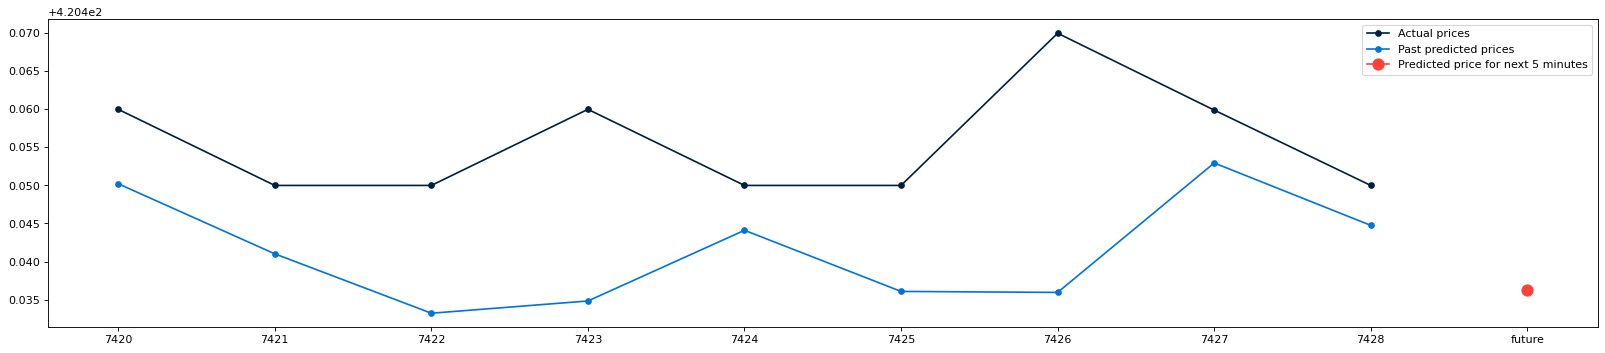

In [20]:
# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
# plot_date_test.tolist()
# plot_date_test.append("tomorrow")

plot_date_test = np.concatenate([plot_date_test, ["future"]])


fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next 5 minutes", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
# plt.title("Predicting the close price of the next trading day")
# plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

# print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))